## Object Detection with YOLOv5

### About
----------------
This notebook provides a guided tour of deploying a YOLOv5 machine learning model pre-trained with MS COCO dataset using PyTorch to a Panorama appliance. More information about the model including the original model itself can be found in [this repository](https://github.com/ultralytics/yolov5) which is also included as a submodule under `3rdparty/yolov5`. More specifically, release `v3.0` of the repository was used to build this example.

This example shows how to prepare a pre-trained model for deployment to a Panorama device. You can also train your own model using the resources from the aforementioned repository and deploy it to a Panorama appliance following the same steps.

This is an example of inference done on an image captured from a test IP camera.

![alt Test image inference results](test-result.png "Test image inference results")

### Imports & config
----------------

*This notebook was tested with Torch v1.6.0 and TorchVision v0.7.0, you may need to upgrade those in case you are running older versions. If you are running this on Amazon SageMaker Notebook Instance then use `conda_python3` kernel*

In [ ]:
!pip install torch==1.6.0 torchvision==0.7.0

Install extra libraries (not needed if using `conda_python3` on SageMaker Notebook Instance)

In [19]:
!pip install boto3

In [1]:
import sys
import time
import os
import random as rnd
import json

from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
import cv2
import torch
import boto3

import utils
print(f'Using torch {torch.__version__}')
print(f'Using python {sys.version_info}')

Using torch 1.6.0
Using python sys.version_info(major=3, minor=6, micro=13, releaselevel='final', serial=0)


***Create your own AWS S3 Bucket making sure it contains `aws-panorama` in the bucket name***

In [2]:
# Set this variable/constant value to be the full name of your bucket, for example "aws-panorama-example-xyz"
BUCKET = 'aws-panorama-<you-bucket-name-suffix>'  # Bucket name must contain "aws-panorama"

# TEMP
BUCKET = 'aws-panorama-demo'

MODELS_S3_PREFIX = 'models'

MODEL = 'yolov5s'
model_file = f'{MODEL}.pt'
traced_model_file = f'{MODEL}.pth'
traced_model_archive = f'{MODEL}.tar.gz'

LAMBDA = 'yolov5s'

LAMBDA_EXECUTION_ROLE_NAME = 'PanoramaYoloLambdaExecutionRole'
lambda_file = f'{LAMBDA}_lambda.py'
lambda_archive = lambda_file.replace('.py', '.zip')

TEST_IMAGE = 'test.png'
INPUT_SIZE = 640 
THRESHOLD = 0.5
CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
           'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
           'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
           'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
           'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
           'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
           'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
           'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
           'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    
if torch.cuda.is_available():
    device_type = 'GPU'
    print(f'Using GPU: {torch.cuda.get_device_properties(0)}')
else:
    device_type = 'CPU'

# Uncomment next like if you want to force running on CPU on a device with GPU
# device_type = 'CPU'

device = torch.device('cuda:0' if device_type == 'GPU' else 'cpu')
print(f'Using {device_type}', end='')

Using CPU

In [5]:
s3_client = boto3.client("s3")
iam_client = boto3.client("iam")
lambda_client = boto3.client("lambda")

### The model
----------------

Model preparation steps are completed using the `3rdparty/yolov5` submodule

##### Steps to prepare the model
1. Download and trace the model
    - Install YOLOv5 dependencies
    - Run a test inference. This will also download the pre-trained model as save it as `yolov5s.pt` file
    - Export the downloaded model to TorchScript format, saved as `yolov5.pth` file
2. Test the TorchScript model
    - Load the TorchScript model
    - Load the test image and prepare it
    - Put the test image through the model
    - Show results
3. Pack and upload the TorchScript model to S3

##### Download and trace

In [21]:
!pip install -r 3rdparty/yolov5/requirements.txt

     |████████████████████████████████| 1.9 MB 928 kB/s eta 0:00:01
     |████████████████████████████████| 249 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 6.6 MB/s eta 0:00:01
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
     |████████████████████████████████| 781 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 7.1 MB/s eta 0:00:01
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Us

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='cpu', img_size=640, iou_thres=0.5, output='inference_results', save_txt=False, source='test.png', update=False, view_img=False, weights=['yolov5s.pt'])
Using CPU

Fusing layers... 
Model Summary: 140 layers, 7.45958e+06 parameters, 6.61683e+06 gradients
image 1/1 /Users/ulmasov/work/REPOS/ulmasov/aws-panorama-samples/Object-Detection-YOLOv5/test.png: 512x640 1 tvs, 1 vases, Done. (0.318s)
Results saved to inference_results
Done. (0.445s)
Namespace(batch_size=1, img_size=[640, 640], weights='yolov5s.pt')

Starting TorchScript export with torch 1.6.0...
/Users/ulmasov/miniconda3/envs/yolov5/lib/python3.6/site-packages/torch/jit/__init__.py:1109: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tu

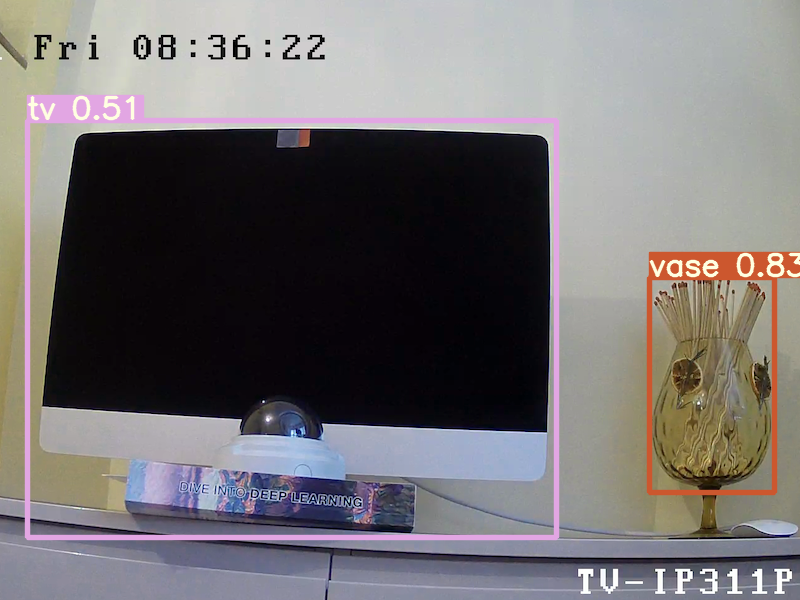

In [33]:
device_str = 'cpu' if device_type == 'CPU' else '0'
out_dir = 'inference_results'
yolov4_dir = '3rdparty/yolov5'

!python $yolov4_dir/detect.py --weights $model_file --img $INPUT_SIZE --conf $THRESHOLD --source $TEST_IMAGE \
    --output $out_dir --device $device_str

!export PYTHONPATH=$yolov4_dir && python $yolov4_dir/models/export.py --weights $model_file --img-size $INPUT_SIZE
!mv yolov5s.torchscript.pt $traced_model_file

Image(filename=f'{out_dir}/{TEST_IMAGE}', width=600)

##### Test the traced model

In [34]:
traced_model = torch.jit.load(traced_model_file, map_location=device)

Use an non-marked version of the test image

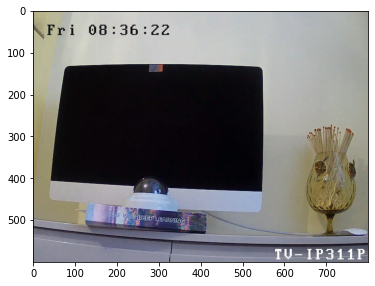

In [36]:
test_image = cv2.cvtColor(cv2.imread(TEST_IMAGE), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(test_image)

Note: output of the YOLOv5 model requires further processing (Non Max Suppression) which can be done on GPU using PyTorch but on a Panorama appliance it needs to be executed on CPU (also applies to execution of model's Detector layer logic), adding significant overhead to the overall inference process.

Pre-process: 11 msec
Inference: 372 msec
Post-process: 19 msec


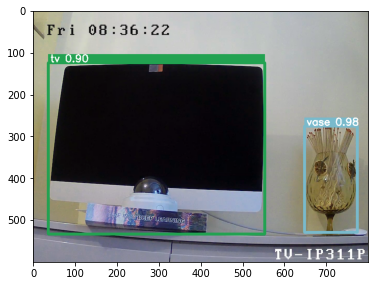

In [37]:
processor = utils.Processor(CLASSES, INPUT_SIZE, threshold=THRESHOLD, keep_ratio=True)

tm = time.time()
img = torch.from_numpy(processor.preprocess(test_image)).to(device)
print(f'Pre-process: {int((time.time() - tm) * 1000)} msec')

# Do a warm-up run before timing inference
traced_model(img)

tm = time.time()
results = traced_model(img)
print(f'Inference: {int((time.time() - tm) * 1000)} msec')
test_results = [r.cpu().numpy() for r in results]

tm = time.time()
_, result_image = processor.post_process(test_results, test_image.shape, test_image.copy())
print(f'Post-process: {int((time.time() - tm) * 1000)} msec')

plt.figure(figsize=(6, 6))
plt.imshow(result_image)

##### Pack and upload the model archive to S3 bucket

Take a note of an S3 location of the uploaded model archive, you'll need it during the application creation process.

In [11]:
!tar -czvf $traced_model_archive $traced_model_file

traced_model_key = os.path.join(MODELS_S3_PREFIX, traced_model_archive)
s3_client.upload_file(traced_model_archive, Bucket=BUCKET, Key=traced_model_key)

traced_model_s3_url = os.path.join(f's3://{BUCKET}', traced_model_key)
print(f'Uploaded model archive to {traced_model_s3_url}')

a yolov5s.pth
Uploaded model archive to s3://{MODEL}/models/yolov5s.tar.gz


Alternatively, you can upload the model archive to S3 bucket using AWS Console or running the following AWS CLI command ***if you have AWS CLI installed and configured*** (change the cell to `Code` type before running)

### The Application 
---------------------

This is the script that will be deployed and executed on the Panorama Appliance as a lambda function. It can found in the same folder as this notebook along with another file `utils.py`, containing some helper scripts.

In [44]:
!pygmentize $lambda_file

import time
import traceback

import panoramasdk
import cv2
import numpy as np

import utils

INPUT_SIZE = 640
MODEL = 'yolov5s'
MODEL_DISPLAY_NAME = 'YOLOv5'
THRESHOLD = 0.5
KEEP_RATIO = True
USE_CV2_RECT = True
CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
           'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
           'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
           'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
           'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
           'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
           'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'key

#### Create and deploy lambda

- If the execution of the code in this cell fails then make sure you have the rights to creates roles in AWS IAM
- You only need to execute the next cell once. All the subsequent deployments will use the same role 

In [ ]:
lambda_execution_role_policy = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}
iam_client.create_role(
    RoleName=LAMBDA_EXECUTION_ROLE_NAME,
    AssumeRolePolicyDocument=json.dumps(lambda_execution_role_policy),
)

##### Create a new function

*Use the cell in the [OPTIONAL] cell below if you want to re-deploy lambda after the initial deployment*

You can inspect the created AWS Lambda Function following the link shown after running the next cell

In [45]:
!zip -o $lambda_archive $lambda_file utils.py

  adding: yolov5s_lambda.py (deflated 65%)
  adding: utils.py (deflated 66%)


In [4]:
with open(lambda_archive, "rb") as f:
    zipped_code = f.read()
    
lambda_execution_role = iam_client.get_role(RoleName=LAMBDA_EXECUTION_ROLE_NAME)

lambda_response = lambda_client.create_function(
    FunctionName=LAMBDA,
    Runtime="python3.7",
    Role=lambda_execution_role["Role"]["Arn"],
    Handler=lambda_file.replace('.py', '.main()'),
    Code=dict(ZipFile=zipped_code),
    Timeout=120,  
    MemorySize=2048,
    Publish=True)

template = "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/{}/versions/{}?tab=configuration"
lambda_url = template.format(lambda_response["FunctionName"], lambda_response["Version"])
print(lambda_url)

https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/yolov5s/versions/1?tab=configuration


##### [OPTIONAL] Subsequent deployments
Convert the next cell to Code and run the following cell if you want to re-deploy the lambda function again, e.g. if you make changes to application code and want to deploy those changes to the Panorama appliance

### Deploy the Application to Panorama appliance 
---------------------

At the time of writing this the only way to deploy the Application to the Panorama device is through the [AWS Panorama Console](https://console.aws.amazon.com/panorama). Instructions for script-based deployment will be added here after alternative means of deployment are available, e.g. via AWS CLI or Python SDK.

Few things to remember when deploying the Application to your Panorama appliance in AWS Panorama Console:

- when creating a new model (as part of a new Application creation process) in AWS Panorama Console:
    - use the model archive uploaded to S3 earlier in this notebook to create a new **External model** (e.g. `s3://< your bucket >/models/yolov5s.tar.gz`)
    - make sure that the **Model name** you specify matches exactly the model name used in your Application/lambda code (it is stored in the variable/constant named **MODEL** in the current version of the Application/labmda code) *
    - select `PyTorch` as *Model framework*
    - add input with **Input name** `data` and **Input shape** `1,3,640,640`
     
- first deployment of the Application takes a bit longer due to initial conversion of the model done by AWS SageMaker Neo behind the scene. Subsequent deployments using the same model will be faster if you only change the Application code (which is usually the case)
- to troubleshoot any issues start with looking at the logs in [AWS CloudWatch](https://console.aws.amazon.com/cloudwatch). In the AWS CloudWatch Console, click on **Log Groups** under **Logs** and select a click on a link that has a name of the lambda function corresponding to your Application (something like `/aws/greengrass/Lambda/us-east-1/<your account number>/yolov5s`)

***Note:*** *code versions may change making it out of sync with comments in this notebook, always use the latest values from the code when referred to*

### What's next?
---------------------

This was just a taster to show you how to run a PyTorch based YOLOv5 model on Panorama appliance. Next logical step would be fine-tuning the pre-trained YOLOv5 model using your own dataset to recognise your own object types. Examples of doing that are available in the `3rdparty/yolov5` submodule.